In [24]:
import numpy as np
from numpy.linalg import matrix_power as mat_pow
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 10]

In [44]:
class WSe2:
    E_mat = np.array([[0.034, 0.329, 0.486],
                      [-0.329, 0.263, 0.457],
                      [0.486, -0.457, -0.207]])
    E_levels = np.diag([2.179, 2.179, 0.943])
    E_0 = E_levels[0, 0] - 3/2*(E_mat[1, 1]+E_mat[0, 0]) - 3*np.sqrt(3)*E_mat[0, 1]
    E_1 = E_levels[2, 2] - 3*E_mat[2, 2]
    λ_SOC = 0.228
    d = 2.4
    λ = 0.3
    
    def __init__(self, m, n, R_max=1):
        self.layer_1 = Supercell(m, n)
        self.layer_2 = Supercell(n, m)
        self.z_hopping = self.layer_1.interlayer_hopping_array(self.layer_2)
        R = np.array([[-1/2, -np.sqrt(3)/2, 0], [np.sqrt(3)/2, -1/2, 0], [0, 0, 1]])
        C_2 = np.diag([1, -1, 1])
        self.E_list = [mat_pow(R, i)@mat_pow(C_2, i)@self.E_mat@(mat_pow(R, i)@mat_pow(C_2, i)).T for i in range(6)]
        z_hopping = self.layer_1.interlayer_hopping_array(self.layer_2)
        self.z_hop = []
        for i in range(self.layer_1.N_atoms):
            self.z_hop += [[(j, z_hopping[i, j]) for j in range(self.layer_2.N_atoms) if np.linalg.norm(z_hopping[i, j])<R_max]]
    
        
    def H_WSe2_mono(self, k, σ, layer, rotate=False):
        if rotate:
            k = np.array([[np.cos(layer.Δθ), -np.sin(layer.Δθ)], [np.sin(layer.Δθ), np.cos(layer.Δθ)]]) @ k
        H = np.zeros((3*layer.N_atoms, 3*layer.N_atoms), dtype=complex)
        for i in range(layer.N_atoms):
            H[3*i:3*(i+1), 3*i:3*(i+1)] = self.E_levels + self.λ_SOC*np.array([[0, 1j*σ, 0], [-1j*σ, 0, 0], [0, 0, 0]])
            for j in range(6):
                m = layer.NN_array[i, j]
                H[3*i:3*(i+1), 3*m:3*(m+1)] = self.E_list[j] * np.exp(1j*np.dot(layer.hop_list[j].vec, k))
        return H
    
    def plot_mono_bands(self, σ, k_list, N_points, layer=None, k_tags=None, **kwargs):
        if layer == None:
            layer = self.layer_1
        spacing, k_path_unit = self.k_path(k_list, N_points)
        N_points = len(k_path_unit)
        k_path_super = self.k_path([layer.reduce_k_point(k) for k in k_list], N_points, spacing)[1]
        #k_path_super = k_path_unit
        ε_supercell = np.zeros((N_points, 3*layer.N_atoms))
        ε_unitcell = np.zeros((N_points, 3))
        for i in range(N_points):
            my_H = (sum([self.E_list[j] * np.exp(1j*np.dot(layer.hop_list[j].vec, k_path_unit[i])) for j in range(6)]) 
                    + self.E_levels + self.λ_SOC*np.array([[0, 1j*σ, 0], [-1j*σ, 0, 0], [0, 0, 0]]))
            ε_unitcell[i, :] = np.linalg.eigh(my_H)[0]
            ε_supercell[i, :] = np.linalg.eigh(self.H_WSe2_mono(k_path_super[i], σ, layer))[0]
        for x in [sum(spacing[:i]) for i in range(len(spacing)+1)]:
            plt.axvline(x=x, linewidth=0.5, color='black', ls='--')
        plt.axhline(y=0, linewidth=0.5, color='black', ls='--')
        plt.axhline(y=self.E_1-self.E_0, linewidth=0.5, color='black', ls='--')
        plt.plot(range(N_points), ε_supercell-self.E_0, c='b')
        plt.plot(range(N_points), ε_unitcell-self.E_0, c='r')
        plt.ylabel('Energy (eV)')
        if k_tags != None:
            plt.xticks([sum(spacing[:i]) for i in range(len(spacing)+1)], k_tags)
            
    def plot_bilayer_bands(self, σ, t_0, k_list, N_points, k_tags=None, print_time=False, **kwargs):
        spacing, k_path_super = self.k_path([self.layer_1.reduce_k_point(k) for k in k_list], N_points)
        N_points = len(k_path_super)
        ε_supercell = np.zeros((N_points, 6*self.layer_1.N_atoms))
        for i in range(N_points):
            startTime = datetime.now()
            ε_supercell[i, :] = np.linalg.eigh(self.H_WSe2_bilayer(k_path_super[i], σ, t_0))[0]
            if print_time:
                print(datetime.now()-startTime)
        for x in [sum(spacing[:i]) for i in range(len(spacing)+1)]:
            plt.axvline(x=x, linewidth=0.5, color='black', ls='--')
        plt.axhline(y=0, linewidth=0.5, color='black', ls='--')
        plt.axhline(y=self.E_1-self.E_0, linewidth=0.5, color='black', ls='--')
        plt.plot(range(N_points), ε_supercell-self.E_0, c='b')
        plt.ylabel('Energy (eV)')
        if k_tags != None:
            plt.xticks([sum(spacing[:i]) for i in range(len(spacing)+1)], k_tags)
        
    
    def k_path(self, k_list, N_points, spacing=None):
        if spacing == None:
            k_norms = [np.linalg.norm(k_list[i+1]-k_list[i]) for i in range(len(k_list)-1)]
            spacing = [int(N_points*k_norms[i]/sum(k_norms)) for i in range(len(k_norms))]
        k_path = []
        for i in range(len(spacing)):
            k_path += [k_list[i] + (k_list[i+1]-k_list[i])*j/spacing[i] for j in range(spacing[i])]
        k_path += [k_list[-1]]
        return spacing, k_path
    
    def H_WSe2_bilayer(self, k, σ, t_0):
        H = np.zeros((6*self.layer_1.N_atoms, 6*self.layer_1.N_atoms), dtype=complex)
        H[0:3*self.layer_1.N_atoms, 0:3*self.layer_1.N_atoms] = self.H_WSe2_mono(k, σ, self.layer_1, rotate=True)
        H[3*self.layer_1.N_atoms:, 3*self.layer_1.N_atoms:] = self.H_WSe2_mono(k, σ, self.layer_2, rotate=True)
        for i in range(self.layer_1.N_atoms):
            for j, hop_vec in self.z_hop[i]:
                t = t_0 * np.exp(-(np.sqrt(np.dot(hop_vec, hop_vec)+self.d**2)-self.d)/self.λ)
                H[3*i+2+3*self.layer_1.N_atoms, 3*j+2] = t * np.exp(1j*np.dot(k, hop_vec))
                H[3*j+2, 3*i+2+3*self.layer_1.N_atoms] = t * np.exp(-1j*np.dot(k, hop_vec))
        return H
        
            

In [6]:
class LatVec:
    a_1 = np.array([1, 0])
    a_2 = np.array([1/2, np.sqrt(3)/2])
    b_1 = 2*np.pi * np.array([1, -1/np.sqrt(3)])
    b_2 = 2*np.pi * np.array([0, 2/np.sqrt(3)])
    
    def __init__(self, i, j, reciprocal=False, scale=1):
        self.i = i
        self.j = j
        self.scale = scale
        self.reciprocal = reciprocal
        self.vec = self.vectorize()
        
    def __add__(self, other):
        return LatVec(self.i+other.i, self.j+other.j)
    
    def __eq__(self, other):
        return (self.i==other.i) & (self.j==other.j)
    
    def __and__(self, other):
        return [self, other.neg(), self.neg()+other.neg(), self.neg(), other, self+other]
    
    def __mul__(self, other):
        if type(other) == LatVec:
            return np.dot(self.vec, other.vec)
        else:
            return np.dot(self.vec, other)
        
    def __rmul__(self, other):
        return self * other
    
    def neg(self):
        return LatVec(-self.i, -self.j)
    
    def vectorize(self):
        if self.reciprocal:
            return self.scale*(self.i*self.b_1 + self.j*self.b_2)
        else:
            return self.scale*(self.i*self.a_1 + self.j*self.a_2)
        
    def rot(self, θ):
        R_θ = np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])
        return R_θ @ self.vec

        

In [7]:
class Supercell:
    hop_list = LatVec(1, 0) & LatVec(0, -1)
    
    def __init__(self, m, n):
        self.v_1 = LatVec(m, n)    
        self.v_2 = LatVec(n+m, -m)
        self.w_1 = LatVec(m, n+m, True, 1/(m**2+m*n+n**2))
        self.w_2 = LatVec(n, -m, True, 1/(m**2+m*n+n**2))
        r = max(m, n)
        self.grid = [LatVec(i, j) for i in range(0, 3*r) for j in range(-r, r+1) if self.in_supercell(i, j)]
        self.N_atoms = len(self.grid)
        self.Δθ = np.arctan((n-m)/(n+m)/np.sqrt(3))
        self.construct_NN_array()
         
    def in_supercell(self, i, j, tol=10**-5):
        M = np.linalg.inv(np.array([self.v_1.vec, self.v_2.vec]).T)
        λ, μ = M @ LatVec(i, j).vec
        in_parellogram = (tol < λ < 1-tol) and (tol < μ < 1-tol) 
        return in_parellogram or (i, j) == (0, 0)
    
    def construct_NN_array(self):
        self.NN_array = np.zeros((self.N_atoms, 6), dtype=int)
        for i in range(self.N_atoms):
            self.NN_array[i, :] = [self.find_NN(i, h_vec) for h_vec in self.hop_list]
            
    def find_NN(self, i, h_vec):
        for lat_vec in (self.v_1 & self.v_2) + [LatVec(0, 0)]:
            if self.grid[i]+h_vec+lat_vec in self.grid:
                return self.grid.index(self.grid[i]+h_vec+lat_vec)
        raise Exception('No NN found for '+str(i)+' '+str(h_vec))
                
    def interlayer_hopping_array(self, supercell, tol=10**-5):
        if self.N_atoms != supercell.N_atoms:
            raise Exception('Supercells have a different number of atoms')
        if np.abs(self.Δθ + supercell.Δθ) > tol:
            raise Exception('Unequal twist angles')
        z_hopping = np.zeros((self.N_atoms, self.N_atoms, 2))
        for i in range(self.N_atoms):
            vec_i = supercell.grid[i].rot(-supercell.Δθ)    
            for j in range(self.N_atoms):
                min_ΔR = 10**6
                for lat_vec in (self.v_1 & self.v_2) + [LatVec(0, 0)]:
                    vec_j_trial = (self.grid[j]+lat_vec).rot(-self.Δθ)
                    if np.linalg.norm(vec_i-vec_j_trial) < min_ΔR:
                        min_ΔR = np.linalg.norm(vec_i-vec_j_trial)
                        vec_j = vec_j_trial
                z_hopping[i, j] = vec_i - vec_j
        return z_hopping
    
    def plot_supercell(self, grid_points=None, *, lat_vec=LatVec(0, 0), rotate=True, **kwargs):
        if grid_points == None:
            grid_points = range(self.N_atoms)
        grid_array = np.array([(self.grid[i]+lat_vec).rot(-self.Δθ*rotate) for i in grid_points])
        plt.scatter(grid_array[:, 0], grid_array[:, 1], **kwargs)
        
    def reduce_k_point(self, k):
        α, β = np.linalg.inv([[self.w_1*self.w_1, self.w_1*self.w_2], [self.w_1*self.w_2, self.w_2*self.w_2]]) @ np.array([np.dot(k, self.w_1.vec), np.dot(k, self.w_2.vec)]).T
        return np.modf(α)[0]*self.w_1.vec + np.modf(β)[0]*self.w_2.vec
        
                
        

In [49]:
n, m = 6, 7
layer_1 = Supercell(n, m)
layer_2 = Supercell(m, n)
z_hopping = layer_1.interlayer_hopping_array(layer_2)
layer_1.Δθ*2*180/np.pi

5.085847808123479

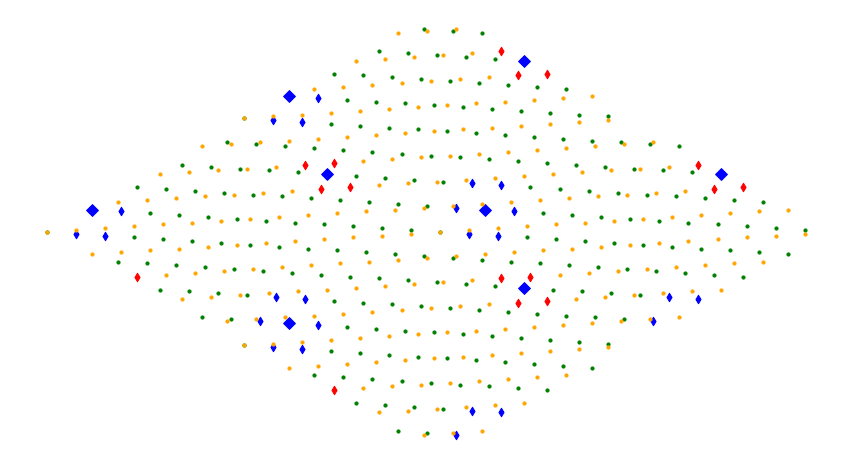

In [22]:

j_1 = 2
j_2 = 44
for lat_vec in [layer_1.v_1+layer_1.v_2, layer_1.v_1,  layer_1.v_2, LatVec(0, 0)]:
    layer_1.plot_supercell(lat_vec=lat_vec, c='green', s=10)
    layer_1.plot_supercell(list(layer_1.NN_array[j_1, :]), lat_vec=lat_vec, c='blue', marker='d')
    layer_1.plot_supercell([j_1], lat_vec=lat_vec, c='blue', s=70, marker='D')
    layer_1.plot_supercell([j_2], lat_vec=lat_vec, c='blue', marker='D', s=70)
for lat_vec in [layer_2.v_1+layer_2.v_2, layer_2.v_1,  layer_2.v_2, LatVec(0, 0)]:
    layer_2.plot_supercell(lat_vec=lat_vec, c='orange', s=10)
    layer_2.plot_supercell([i for i in range(layer_2.N_atoms) if np.linalg.norm(z_hopping[i, j_2]) < 1], lat_vec=lat_vec, c='red', marker='d')

plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.savefig("bilayer_hopping", bbox_inches='tight')

[array([0., 0.]), array([-3.14159265, -1.81379936]), array([-4.1887902,  0.       ]), array([0, 0]), array([4.1887902, 0.       ]), array([3.14159265, 1.81379936]), array([0., 0.])]
[array([0., 0.]), array([-0.49604095, -0.66824187]), array([-0.88185057, -0.3818525 ]), array([0., 0.]), array([0.88185057, 0.3818525 ]), array([0.49604095, 0.66824187]), array([0., 0.])]


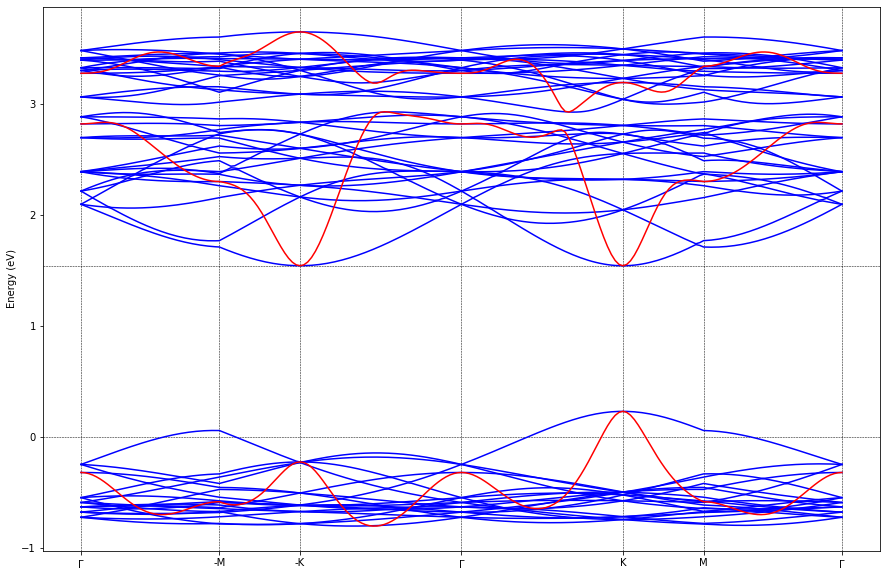

In [9]:
model = WSe2(3, 2)
k_list = [np.zeros(2), np.array([-np.pi, -np.pi/np.sqrt(3)]), np.array([-4*np.pi/3, 0]), np.array([0, 0]), np.array([4*np.pi/3, 0]), np.array([np.pi, np.pi/np.sqrt(3)]), np.zeros(2)]
model.plot_mono_bands(1, k_list, 200, k_tags=[r'$\Gamma$', '-M', '-K', r'$\Gamma$', 'K', 'M', r'$\Gamma$'])
plt.savefig("monolayer_dispersion", bbox_inches='tight')

0:00:00.241216
0:00:00.238445
0:00:00.244332
0:00:00.253277
0:00:00.239177
0:00:00.241284
0:00:00.240863
0:00:00.239801
0:00:00.248840
0:00:00.240396
0:00:00.249283
0:00:00.242041
0:00:00.238179
0:00:00.243043
0:00:00.242193
0:00:00.240352
0:00:00.242649
0:00:00.242976
0:00:00.240396
0:00:00.242703
0:00:00.241203
0:00:00.244728
0:00:00.241864
0:00:00.241847
0:00:00.241976
0:00:00.257564
0:00:00.242334
0:00:00.242555
0:00:00.240572
0:00:00.243777
0:00:00.240703
0:00:00.241636
0:00:00.240115
0:00:00.251133
0:00:00.255212
0:00:00.240941
0:00:00.241354
0:00:00.263554
0:00:00.250324
0:00:00.261826
0:00:00.241117
0:00:00.242287
0:00:00.240778
0:00:00.241479
0:00:00.242079
0:00:00.243064
0:00:00.241177
0:00:00.239646
0:00:00.240905
0:00:00.242926
0:00:00.239465
0:00:00.240552
0:00:00.241457
0:00:00.241386
0:00:00.240792
0:00:00.241866
0:00:00.240661
0:00:00.240289
0:00:00.241408
0:00:00.240452
0:00:00.240452
0:00:00.246232
0:00:00.244378
0:00:00.238592
0:00:00.241332
0:00:00.241018
0:00:00.25

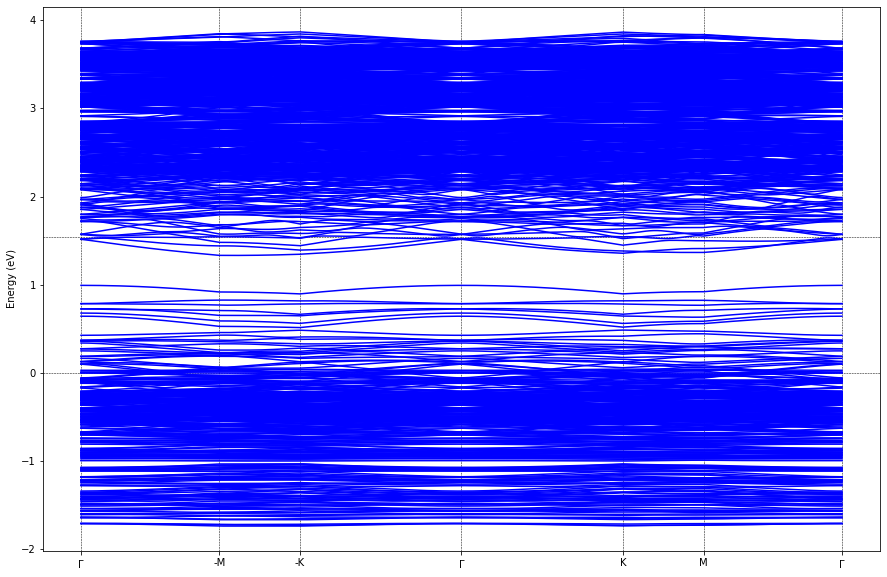

In [50]:
model = WSe2(6, 7)
k_list = [np.zeros(2), np.array([-np.pi, -np.pi/np.sqrt(3)]), np.array([-4*np.pi/3, 0]), np.array([0, 0]), np.array([4*np.pi/3, 0]), np.array([np.pi, np.pi/np.sqrt(3)]), np.zeros(2)]
model.plot_bilayer_bands(1, 0.5, k_list, 200, k_tags=[r'$\Gamma$', '-M', '-K', r'$\Gamma$', 'K', 'M', r'$\Gamma$'], print_time=True)


In [17]:
my_lst = [np.zeros(2), np.ones(2), np.array([1, 2]), np.array([1, 3])]
np.isin(np.array([1, 3]), my_lst)

array([ True,  True])

In [18]:
np.any([np.all(elem==np.array([1, 3])) for elem in my_lst])

True

In [27]:
print(i for i in np.array([1, 0, 0]))

<generator object <genexpr> at 0x7fd0e62c3f50>


In [19]:
H = np.zeros((6, 6), dtype=complex)

In [110]:
(1j + 3)**2

(8+6j)

In [111]:
int(1.3)

1

In [28]:
np.array([1, 2], dtype=complex)

array([1.+0.j, 2.+0.j])

In [78]:
type(model) == WSe2

True

In [62]:
np.exp(1j*np.pi*2/3)

(-0.4999999999999998+0.8660254037844387j)

In [1]:
200 * 12 * 6

14400

In [3]:
(40000/14400)**(1/40)

1.0258702545394935

In [4]:
1.025**40

2.685063838389963

In [3]:
np.dot([1, 1], [1, 1])

2

In [12]:
sadjhsd + 3

NameError: name 'sadjhsd' is not defined

In [18]:
[i for i in range(3) if i !=1]

[0, 2]

In [23]:
a = []
a += [[2, 3]]

In [24]:
a

[[2, 3]]